<a href="https://colab.research.google.com/github/elizabethts/Predicting_Scalar_Coupling_Constants/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [2]:
# !pip install kaggle
# !mkdir .kaggle

import json
token = {"username":"chancedurr","key":"05529f8f357c5b341a00c7f9fb072dae"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

!chmod 600 /root/.kaggle/kaggle.json


!kaggle competitions download -c champs-scalar-coupling

- path is now set to: {/content}
 72% 32.0M/44.5M [00:00<00:00, 62.9MB/s]
100% 44.5M/44.5M [00:00<00:00, 112MB/s] 
 60% 8.00M/13.4M [00:00<00:00, 82.3MB/s]
100% 13.4M/13.4M [00:00<00:00, 85.5MB/s]
 97% 61.0M/62.9M [00:00<00:00, 109MB/s] 
100% 62.9M/62.9M [00:00<00:00, 142MB/s]
 84% 41.0M/48.7M [00:00<00:00, 108MB/s] 
100% 48.7M/48.7M [00:00<00:00, 140MB/s]
 98% 85.0M/86.6M [00:00<00:00, 75.9MB/s]
100% 86.6M/86.6M [00:00<00:00, 136MB/s] 
  0% 0.00/5.31M [00:00<?, ?B/s]
100% 5.31M/5.31M [00:00<00:00, 177MB/s]
  0% 0.00/497k [00:00<?, ?B/s]
100% 497k/497k [00:00<00:00, 68.2MB/s]
 54% 5.00M/9.24M [00:00<00:00, 51.2MB/s]
100% 9.24M/9.24M [00:00<00:00, 58.9MB/s]
 98% 49.0M/49.8M [00:00<00:00, 110MB/s]
100% 49.8M/49.8M [00:00<00:00, 112MB/s]
  0% 0.00/965k [00:00<?, ?B/s]
100% 965k/965k [00:00<00:00, 138MB/s]


In [3]:
!pip install category_encoders eli5 shap

from category_encoders import OrdinalEncoder, OneHotEncoder
import eli5
from eli5.sklearn import PermutationImportance

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial
from tqdm import tqdm_notebook as tqdm

import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

     |████████████████████████████████| 92kB 3.4MB/s 
     |████████████████████████████████| 102kB 27.8MB/s 
     |████████████████████████████████| 235kB 47.8MB/s 
  Created wheel for shap: filename=shap-0.29.3-cp36-cp36m-linux_x86_64.whl size=344733 sha256=feba76214ffcad29cb0e32a671fc5317d0989f6064b7a3387f71a191dbd9f1bc
  Stored in directory: /root/.cache/pip/wheels/00/20/87/d199e4d7397997f5494e4098104f91313ac8120753bee7b032
Successfully built shap


In [4]:
# !unzip /content/{/content}/competitions/champs-scalar-coupling/dipole_moments.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/structures.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/scalar_coupling_contributions.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/magnetic_shielding_tensors.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/mulliken_charges.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/potential_energy.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/test.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/train.csv.zip

Archive:  /content/{/content}/competitions/champs-scalar-coupling/dipole_moments.csv.zip
  inflating: dipole_moments.csv      
Archive:  /content/{/content}/competitions/champs-scalar-coupling/structures.csv.zip
  inflating: structures.csv          
Archive:  /content/{/content}/competitions/champs-scalar-coupling/scalar_coupling_contributions.csv.zip
  inflating: scalar_coupling_contributions.csv  
Archive:  /content/{/content}/competitions/champs-scalar-coupling/magnetic_shielding_tensors.csv.zip
  inflating: magnetic_shielding_tensors.csv  
Archive:  /content/{/content}/competitions/champs-scalar-coupling/mulliken_charges.csv.zip
  inflating: mulliken_charges.csv    
Archive:  /content/{/content}/competitions/champs-scalar-coupling/potential_energy.csv.zip
  inflating: potential_energy.csv    
Archive:  /content/{/content}/competitions/champs-scalar-coupling/test.csv.zip
  inflating: test.csv                
Archive:  /content/{/content}/competitions/champs-scalar-coupling/train.csv

In [0]:
trainval = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/train.csv.zip')
test = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/test.csv.zip')
structures = pd.read_csv('/content/structures.csv')
dipole = pd.read_csv('/content/dipole_moments.csv')
contrib = pd.read_csv('/content/scalar_coupling_contributions.csv')
magnetic = pd.read_csv('/content/magnetic_shielding_tensors.csv')
mulliken = pd.read_csv('/content/mulliken_charges.csv')
potential_energy = pd.read_csv('/content/potential_energy.csv')
test_mulliken = pd.read_csv('/content/mulliken_charges_test_set.csv')

## Reduce Memory Function

In [0]:
def reduce_mem_usage(df, verbose=True):
    """
    This function reduces the numeric to the least possible numeric type that fits the data so 
    memory usage during transforming and training will be reduced.
    Taken from: https://www.kaggle.com/todnewman/keras-neural-net-for-champs
    
    Han
    Parameters:
    ===========
    dataframe: input dataframe 
    verbose: verbose mode, default True.
    Output:
    ===========
    dataframe: dataframe with numeric columns types changed to the least possible size
    """

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Create features on structures

In [11]:
%%time
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}



Calculating bonds



Counting and condensing bonds


,molecule_name,atom_index,atom,x,y,z,EN,rad,n_bonds,bond_lengths_mean
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,2.20,0.43,1,1.091953
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,2.20,0.43,1,1.091946
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,2.20,0.43,1,1.091948
5,dsgdb9nsd_000002,0,N,-0.040426,1.024108,0.062564,3.04,0.80,3,1.017195
6,dsgdb9nsd_000002,1,H,0.017257,0.012545,-0.027377,2.20,0.43,1,1.017190
7,dsgdb9nsd_000002,2,H,0.915789,1.358745,-0.028758,2.20,0.43,1,1.017187
8,dsgdb9nsd_000002,3,H,-0.520278,1.343532,-0.775543,2.20,0.43,1,1.017208
9,dsgdb9nsd_000003,0,O,-0.034360,0.977540,0.007602,3.44,0.78,2,0.962107


CPU times: user 1min 30s, sys: 1.24 s, total: 1min 31s
Wall time: 1min 31s


## Merge structures function

In [0]:
def merge_train_structures(train, structures):
  
  """This function is used to merge the structures dataset to the 
     original train dataset
     
     Parameters:
     ===========
	   train: train dataframe
	   structures: structures dataframe.
     
     Output:
	   ===========
	   dataframe: merged dataframe
     """
  
  structures = structures.rename({'atom_index': 'atom_index_0',
                                  'x':'x_0', 'y':'y_0', 'z':'z_0',
                                  'atom':'atom_0'}, axis=1)
  
  merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])
  
  structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)
  
  merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])
  
  structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
  
  assert train.shape[0] == merged.shape[0]
  
  return merged_1

In [0]:
merged = merge_train_structures(trainval, structures)

In [14]:
assert len(merged) == len(trainval)
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,2.2,0.43,1,1.091948,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952


In [0]:
mulliken = mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_1'])
assert len(merged) == len(trainval)

## Feature Engineering

In [16]:
%%time
# This block is SPPED UP

train_p_0 = merged[['x_0', 'y_0', 'z_0']].values
train_p_1 = merged[['x_1', 'y_1', 'z_1']].values
# test_p_0 = test[['x_0', 'y_0', 'z_0']].values
# test_p_1 = test[['x_1', 'y_1', 'z_1']].values

merged['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
# test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
assert len(merged) == len(trainval)

CPU times: user 854 ms, sys: 605 ms, total: 1.46 s
Wall time: 1.46 s


In [17]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,mulliken_charge_0,mulliken_charge_1,dist
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133921,-0.535689,1.091953
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,2.2,0.43,1,1.091952,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133922,-0.535689,1.091952
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,2.2,0.43,1,1.091946,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133923,-0.535689,1.091946
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,2.2,0.43,1,1.091948,C,-0.012698,1.085804,0.008001,2.55,0.82,4,1.091950,0.133923,-0.535689,1.091948
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,2.2,0.43,1,1.091953,H,1.011731,1.463751,0.000277,2.20,0.43,1,1.091952,0.133921,0.133922,1.783120


In [18]:
%%time

external_data_0 = pd.DataFrame(data={
    'atom_0': ['C', 'H', 'N', 'O', 'F'],
    'atom_0_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_0': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_0': [4, 1, 5, 6, 7]
})
external_data_1 = pd.DataFrame(data={
    'atom_1': ['C', 'H', 'N', 'O', 'F'],
    'atom_1_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_1': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_1': [4, 1, 5, 6, 7]
})

def create_features(df):
    df['bond'] = df['type'].str[2:]
    df['j_type'] = df['type'].str[:2]
    df['distance'] = ((df['x_1'].values - df['x_0'].values)**2 + 
                    (df['y_1'].values - df['y_0'].values)**2 + 
                    (df['z_1'].values - df['z_0'].values)**2)** 0.5
    df['mu_0'] = np.sqrt(df['x_0'].values**2 + df['y_0'].values**2 + df['z_0'].values**2)
    df['mu_1'] = np.sqrt(df['x_1'].values**2 + df['y_1'].values**2 + df['z_1'].values**2)
    df = df.merge(external_data_0, on='atom_0', how='left')
    df = df.merge(external_data_1, on='atom_1', how='left')
    df['delta_en'] = (df['atom_0_en'] - df['atom_1_en']).abs()
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['dist'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['dist'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['dist'].transform('max')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
    df['molecule_atom_index_0_x_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['x_1'].transform('std')
    df['molecule_atom_index_0_y_1_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('mean')
    df['molecule_atom_index_0_y_1_mean_diff'] = df[f'molecule_atom_index_0_y_1_mean'] - df['y_1']
    df['molecule_atom_index_0_y_1_mean_div'] = df[f'molecule_atom_index_0_y_1_mean'] / df['y_1']
    df['molecule_atom_index_0_y_1_max'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('max')
    df['molecule_atom_index_0_y_1_max_diff'] = df[f'molecule_atom_index_0_y_1_max'] - df['y_1']
    df['molecule_atom_index_0_y_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['y_1'].transform('std')
    df['molecule_atom_index_0_z_1_std'] = df.groupby(['molecule_name', 'atom_index_0'])['z_1'].transform('std')
    df['molecule_atom_index_0_dist_mean'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('mean')
    df['molecule_atom_index_0_dist_mean_diff'] = df[f'molecule_atom_index_0_dist_mean'] - df['dist']
    df['molecule_atom_index_0_dist_mean_div'] = df[f'molecule_atom_index_0_dist_mean'] / df['dist']
    df['molecule_atom_index_0_dist_max'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('max')
    df['molecule_atom_index_0_dist_max_diff'] = df[f'molecule_atom_index_0_dist_max'] - df['dist']
    df['molecule_atom_index_0_dist_max_div'] = df[f'molecule_atom_index_0_dist_max'] / df['dist']
    df['molecule_atom_index_0_dist_min'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df['molecule_atom_index_0_dist_min_diff'] = df[f'molecule_atom_index_0_dist_min'] - df['dist']
    df['molecule_atom_index_0_dist_min_div'] = df[f'molecule_atom_index_0_dist_min'] / df['dist']
    df['molecule_atom_index_0_dist_std'] = df.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('std')
    df['molecule_atom_index_0_dist_std_diff'] = df[f'molecule_atom_index_0_dist_std'] - df['dist']
    df['molecule_atom_index_0_dist_std_div'] = df[f'molecule_atom_index_0_dist_std'] / df['dist']
    df['molecule_atom_index_1_dist_mean'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('mean')
    df['molecule_atom_index_1_dist_mean_diff'] = df[f'molecule_atom_index_1_dist_mean'] - df['dist']
    df['molecule_atom_index_1_dist_mean_div'] = df[f'molecule_atom_index_1_dist_mean'] / df['dist']
    df['molecule_atom_index_1_dist_max'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('max')
    df['molecule_atom_index_1_dist_max_diff'] = df[f'molecule_atom_index_1_dist_max'] - df['dist']
    df['molecule_atom_index_1_dist_max_div'] = df[f'molecule_atom_index_1_dist_max'] / df['dist']
    df['molecule_atom_index_1_dist_min'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('min')
    df['molecule_atom_index_1_dist_min_diff'] = df[f'molecule_atom_index_1_dist_min'] - df['dist']
    df['molecule_atom_index_1_dist_min_div'] = df[f'molecule_atom_index_1_dist_min'] / df['dist']
    df['molecule_atom_index_1_dist_std'] = df.groupby(['molecule_name', 'atom_index_1'])['dist'].transform('std')
    df['molecule_atom_index_1_dist_std_diff'] = df[f'molecule_atom_index_1_dist_std'] - df['dist']
    df['molecule_atom_index_1_dist_std_div'] = df[f'molecule_atom_index_1_dist_std'] / df['dist']
    df['molecule_atom_1_dist_mean'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('mean')
    df['molecule_atom_1_dist_min'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('min')
    df['molecule_atom_1_dist_min_diff'] = df[f'molecule_atom_1_dist_min'] - df['dist']
    df['molecule_atom_1_dist_min_div'] = df[f'molecule_atom_1_dist_min'] / df['dist']
    df['molecule_atom_1_dist_std'] = df.groupby(['molecule_name', 'atom_1'])['dist'].transform('std')
    df['molecule_atom_1_dist_std_diff'] = df[f'molecule_atom_1_dist_std'] - df['dist']
#     df['molecule_type_0_dist_std'] = df.groupby(['molecule_name', 'type_0'])['dist'].transform('std')
#     df['molecule_type_0_dist_std_diff'] = df[f'molecule_type_0_dist_std'] - df['dist']
#     df['molecule_type_dist_mean'] = df.groupby(['molecule_name', 'type'])['dist'].transform('mean')
#     df['molecule_type_dist_mean_diff'] = df[f'molecule_type_dist_mean'] - df['dist']
#     df['molecule_type_dist_mean_div'] = df[f'molecule_type_dist_mean'] / df['dist']
#     df['molecule_type_dist_max'] = df.groupby(['molecule_name', 'type'])['dist'].transform('max')
#     df['molecule_type_dist_min'] = df.groupby(['molecule_name', 'type'])['dist'].transform('min')
#     df['molecule_type_dist_std'] = df.groupby(['molecule_name', 'type'])['dist'].transform('std')
#     df['molecule_type_dist_std_diff'] = df[f'molecule_type_dist_std'] - df['dist']
    df = reduce_mem_usage(df)
    return df

CPU times: user 2.27 ms, sys: 0 ns, total: 2.27 ms
Wall time: 2.27 ms


In [0]:
def map_atom_info(df_1,df_2, atom_idx):
    df = pd.merge(df_1, df_2, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    df = df.drop('atom_index', axis=1)

    return df

def create_closest(df_train):
    #I apologize for my poor coding skill. Please make the better one.
    df_temp=df_train.loc[:,["molecule_name","atom_index_0","atom_index_1","dist","x_0","y_0","z_0","x_1","y_1","z_1"]].copy()
    df_temp_=df_temp.copy()
    df_temp_= df_temp_.rename(columns={'atom_index_0': 'atom_index_1',
                                       'atom_index_1': 'atom_index_0',
                                       'x_0': 'x_1',
                                       'y_0': 'y_1',
                                       'z_0': 'z_1',
                                       'x_1': 'x_0',
                                       'y_1': 'y_0',
                                       'z_1': 'z_0'})
#     df_temp=pd.concat(objs=[df_temp,df_temp_],axis=0)

    df_temp["min_distance"]=df_temp.groupby(['molecule_name', 'atom_index_0'])['dist'].transform('min')
    df_temp= df_temp[df_temp["min_distance"]==df_temp["dist"]]

    df_temp=df_temp.drop(['x_0','y_0','z_0','min_distance'], axis=1)
    df_temp= df_temp.rename(columns={'atom_index_0': 'atom_index',
                                     'atom_index_1': 'atom_index_closest',
                                     'distance': 'distance_closest',
                                     'x_1': 'x_closest',
                                     'y_1': 'y_closest',
                                     'z_1': 'z_closest'})

    for atom_idx in [0,1]:
        df_train = map_atom_info(df_train,df_temp, atom_idx)
        df_train = df_train.rename(columns={'atom_index_closest': f'atom_index_closest_{atom_idx}',
                                            'distance_closest': f'distance_closest_{atom_idx}',
                                            'x_closest': f'x_closest_{atom_idx}',
                                            'y_closest': f'y_closest_{atom_idx}',
                                            'z_closest': f'z_closest_{atom_idx}'})
    df_train = reduce_mem_usage(df_train)
    return df_train

#dtrain = create_closest(train)
#dtest = create_closest(test)
#print('dtrain size',dtrain.shape)
#print('dtest size',dtest.shape)

In [20]:
%%time
merged = create_features(merged)
assert len(merged) == len(trainval)

Mem. usage decreased to 915.13 Mb (68.6% reduction)
CPU times: user 1min 5s, sys: 6.66 s, total: 1min 12s
Wall time: 1min 11s


In [21]:
%%time
dtrain = create_closest(merged)

Mem. usage decreased to 999.53 Mb (2.6% reduction)
CPU times: user 54 s, sys: 513 ms, total: 54.5 s
Wall time: 54.5 s


In [0]:
assert len(dtrain) == len(trainval)

In [24]:
def add_cos_features(df):
    df["distance_0"]=((df['x_0']-df['x_closest_0'])**2+(df['y_0']-df['y_closest_0'])**2+(df['z_0']-df['z_closest_0'])**2)**(1/2)
    df["distance_1"]=((df['x_1']-df['x_closest_1'])**2+(df['y_1']-df['y_closest_1'])**2+(df['z_1']-df['z_closest_1'])**2)**(1/2)
    df["vec_0_x"]=(df['x_0']-df['x_closest_0'])/df["distance_0"]
    df["vec_0_y"]=(df['y_0']-df['y_closest_0'])/df["distance_0"]
    df["vec_0_z"]=(df['z_0']-df['z_closest_0'])/df["distance_0"]
    df["vec_1_x"]=(df['x_1']-df['x_closest_1'])/df["distance_1"]
    df["vec_1_y"]=(df['y_1']-df['y_closest_1'])/df["distance_1"]
    df["vec_1_z"]=(df['z_1']-df['z_closest_1'])/df["distance_1"]
    df["vec_x"]=(df['x_1']-df['x_0'])/df["dist"]
    df["vec_y"]=(df['y_1']-df['y_0'])/df["dist"]
    df["vec_z"]=(df['z_1']-df['z_0'])/df["dist"]
    df["cos_0_1"]=df["vec_0_x"]*df["vec_1_x"]+df["vec_0_y"]*df["vec_1_y"]+df["vec_0_z"]*df["vec_1_z"]
    df["cos_0"]=df["vec_0_x"]*df["vec_x"]+df["vec_0_y"]*df["vec_y"]+df["vec_0_z"]*df["vec_z"]
    df["cos_1"]=df["vec_1_x"]*df["vec_x"]+df["vec_1_y"]*df["vec_y"]+df["vec_1_z"]*df["vec_z"]
    df=df.drop(['vec_0_x','vec_0_y','vec_0_z','vec_1_x','vec_1_y','vec_1_z','vec_x','vec_y','vec_z'], axis=1)
    df = reduce_mem_usage(df)
    return df
    
merged = add_cos_features(dtrain)
#test = add_cos_features(test)

#print('train size',train.shape)
#print('test size',test.shape)

# assert len(merged) == len(trainval)

Mem. usage decreased to 1043.95 Mb (0.0% reduction)


In [25]:
assert len(merged) == len(trainval)
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,mulliken_charge_0,mulliken_charge_1,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,...,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.133911,-0.535645,1.091797,HC,1J,1.091797,0.006702,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,...,1.632812,1.091797,0.000000,1.000000,0.345703,-0.746582,0.316406,1.091797,-0.000003,1.0,1.091797,0.000000,1.0,1.091797,-0.000007,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000007,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
1,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.779297,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,...,1.632812,1.091797,0.000000,1.000000,0.399170,-0.692871,0.365479,1.091797,-0.000002,1.0,1.091797,0.000001,1.0,1.091797,-0.000005,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000005,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
2,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.776367,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,...,1.632812,1.091797,0.000000,1.000000,0.488770,-0.603027,0.447510,1.091797,0.000003,1.0,1.091797,0.000007,1.0,1.091797,0.000000,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,0.000000,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
3,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,2.199219,0.429932,1,1.091797,C,-0.012695,1.085938,0.008003,2.550781,0.819824,4,1.091797,0.133911,-0.535645,1.091797,HC,1J,1.091797,1.778320,1.085938,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,10,1.506836,1.091797,...,1.000000,1.091797,0.000000,1.000000,NaN,NaN,NaN,1.091797,0.000002,1.0,1.091797,0.000006,1.0,1.091797,-0.000001,1.0,0.000003,-1.091797,0.000003,1.091797,1.091797,-0.000001,1.0,0.000003,-1.091797,0,1.091797,-0.012695,1.085938,0.008003,NaN,NaN,NaN,NaN,NaN,1.091797,NaN,NaN,NaN,NaN
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,2.199219,0.429932,1,1.091797,H,1.011719,1.463867,0.000277,2.199219,0.429932,1,1.091797,0.133911,0.133911,1.783203,HH,2J,1.783203,0.006702,1.779297,2.199219,1.007812,1,2.199219,1.007812,1,

## Scoring Function

In [0]:
groups = merged['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
  maes = (y_true - y_pred).abs().groupby(groups).mean()
  return np.log(maes.map(lambda x: max(x, floor))).mean()

## Splitting

In [0]:
trainval_1JHC = merged[merged['type'] == '1JHC']
trainval_1JHN = merged[merged['type'] == '1JHN']
trainval_2JHH = merged[merged['type'] == '2JHH']
trainval_2JHN = merged[merged['type'] == '2JHN']
trainval_2JHC = merged[merged['type'] == '2JHC']
trainval_3JHH = merged[merged['type'] == '3JHH']
trainval_3JHC = merged[merged['type'] == '3JHC']
trainval_3JHN = merged[merged['type'] == '3JHN']

In [0]:
train_1JHC, val_1JHC = train_test_split(trainval_1JHC, shuffle=False, random_state=47)

train_1JHC_molecules = train_1JHC['molecule_name'].unique()
val_1JHC_molecules = np.delete(val_1JHC['molecule_name'].unique(), 0)

train_1JHC = train_1JHC[train_1JHC['molecule_name'].isin(train_1JHC_molecules)]
val_1JHC = val_1JHC[val_1JHC['molecule_name'].isin(val_1JHC_molecules)]

In [0]:
train_1JHN, val_1JHN = train_test_split(trainval_1JHN, shuffle=False, random_state=47)

train_1JHN_molecules = train_1JHN['molecule_name'].unique()
val_1JHN_molecules = np.delete(val_1JHN['molecule_name'].unique(), 0)

train_1JHN = train_1JHN[train_1JHN['molecule_name'].isin(train_1JHN_molecules)]
val_1JHN = val_1JHN[val_1JHN['molecule_name'].isin(val_1JHN_molecules)]

In [0]:
train_2JHH, val_2JHH = train_test_split(trainval_2JHH, shuffle=False, random_state=47)

train_2JHH_molecules = train_2JHH['molecule_name'].unique()
val_2JHH_molecules = np.delete(val_2JHH['molecule_name'].unique(), 0)

train_2JHH = train_2JHH[train_2JHH['molecule_name'].isin(train_2JHH_molecules)]
val_2JHH = val_2JHH[val_2JHH['molecule_name'].isin(val_2JHH_molecules)]

In [0]:
train_2JHN, val_2JHN = train_test_split(trainval_2JHN, shuffle=False, random_state=47)

train_2JHN_molecules = train_2JHN['molecule_name'].unique()
val_2JHN_molecules = np.delete(val_2JHN['molecule_name'].unique(), 0)

train_2JHN = train_2JHN[train_2JHN['molecule_name'].isin(train_2JHN_molecules)]
val_2JHN = val_2JHN[val_2JHN['molecule_name'].isin(val_2JHN_molecules)]

In [0]:
train_2JHC, val_2JHC = train_test_split(trainval_2JHC, shuffle=False, random_state=47)

train_2JHC_molecules = train_2JHC['molecule_name'].unique()
val_2JHC_molecules = np.delete(val_2JHC['molecule_name'].unique(), 0)

train_2JHC = train_2JHC[train_2JHC['molecule_name'].isin(train_2JHC_molecules)]
val_2JHC = val_2JHC[val_2JHC['molecule_name'].isin(val_2JHC_molecules)]

In [0]:
train_3JHH, val_3JHH = train_test_split(trainval_3JHH, shuffle=False, random_state=47)

train_3JHH_molecules = train_3JHH['molecule_name'].unique()
val_3JHH_molecules = np.delete(val_3JHH['molecule_name'].unique(), 0)

train_3JHH = train_3JHH[train_3JHH['molecule_name'].isin(train_3JHH_molecules)]
val_3JHH = val_3JHH[val_3JHH['molecule_name'].isin(val_3JHH_molecules)]

In [0]:
train_3JHC, val_3JHC = train_test_split(trainval_3JHC, shuffle=False, random_state=47)

train_3JHC_molecules = train_3JHC['molecule_name'].unique()
val_3JHC_molecules = np.delete(val_3JHC['molecule_name'].unique(), 0)

train_3JHC = train_3JHC[train_3JHC['molecule_name'].isin(train_3JHC_molecules)]
val_3JHC = val_3JHC[val_3JHC['molecule_name'].isin(val_3JHC_molecules)]

In [0]:
train_3JHN, val_3JHN = train_test_split(trainval_3JHN, shuffle=False, random_state=47)

train_3JHN_molecules = train_3JHN['molecule_name'].unique()
val_3JHN_molecules = np.delete(val_3JHN['molecule_name'].unique(), 0)

train_3JHN = train_3JHN[train_3JHN['molecule_name'].isin(train_3JHN_molecules)]
val_3JHN = val_3JHN[val_3JHN['molecule_name'].isin(val_3JHN_molecules)]

## X_train, y_train, X_val, y_val

In [0]:
new_features_1 = ['EN_x', 'rad_x', 'n_bonds_x', 'bond_lengths_mean_x', 'EN_y', 'rad_y', 'n_bonds_y', 
                     'bond_lengths_mean_y','molecule_couples', 'molecule_dist_mean','molecule_dist_min', 'molecule_dist_max']
new_features_2 = ['atom_0_couples_count', 'atom_1_couples_count', 'molecule_atom_index_0_x_1_std', 
                  'molecule_atom_index_0_y_1_mean', 'molecule_atom_index_0_y_1_mean_diff', 
                  'molecule_atom_index_0_y_1_mean_div', 'molecule_atom_index_0_y_1_max',
                  'molecule_atom_index_0_y_1_max_diff', 'molecule_atom_index_0_y_1_std' ]
new_features_3 = ['molecule_atom_index_0_z_1_std',
                   'molecule_atom_index_0_dist_mean',
                   'molecule_atom_index_0_dist_mean_diff',
                   'molecule_atom_index_0_dist_mean_div',
                   'molecule_atom_index_0_dist_max',
                   'molecule_atom_index_0_dist_max_diff',
                   'molecule_atom_index_0_dist_max_div',
                   'molecule_atom_index_0_dist_min',
                   'molecule_atom_index_0_dist_min_diff',
                   'molecule_atom_index_0_dist_min_div',
                   'molecule_atom_index_0_dist_std',
                   'molecule_atom_index_0_dist_std_diff',
                   'molecule_atom_index_0_dist_std_div',
                   'molecule_atom_index_1_dist_mean',
                   'molecule_atom_index_1_dist_mean_diff',
                   'molecule_atom_index_1_dist_mean_div',
                   'molecule_atom_index_1_dist_max',
                   'molecule_atom_index_1_dist_max_diff',
                   'molecule_atom_index_1_dist_max_div',
                   'molecule_atom_index_1_dist_min',
                   'molecule_atom_index_1_dist_min_diff',
                   'molecule_atom_index_1_dist_min_div',
                   'molecule_atom_index_1_dist_std',
                   'molecule_atom_index_1_dist_std_diff',
                   'molecule_atom_index_1_dist_std_div',
                   'molecule_atom_1_dist_mean',
                   'molecule_atom_1_dist_min',
                   'molecule_atom_1_dist_min_diff',
                   'molecule_atom_1_dist_min_div',
                   'molecule_atom_1_dist_std',
                   'molecule_atom_1_dist_std_diff']

new_features_4 = ['atom_index_closest_0',
                   'dist_y',
                   'x_closest_0',
                   'y_closest_0',
                   'z_closest_0',
                   'atom_index_closest_1',
                   'dist',
                   'x_closest_1',
                   'y_closest_1',
                   'z_closest_1',
                   'distance_0',
                   'distance_1',
                   'cos_0_1',
                   'cos_0',
                   'cos_1']


features = ['atom_index_0', 'atom_index_1', 'distance', 'atom_0_en',
            'atom_1_en', 'mu_0', 'mu_1', 'mulliken_charge_0',
            'mulliken_charge_1', 'x_0', 'x_1', 'y_0', 'y_1', 'z_0', 'z_1'] + new_features_1 + new_features_2 + new_features_3 + new_features_4

drop_feat = [
    'molecule_atom_index_0_x_1_std',
    'molecule_atom_index_0_y_1_mean_div',
    'molecule_atom_index_0_y_1_std',
    'molecule_atom_index_0_z_1_std',
    'molecule_atom_index_0_dist_std',
    'molecule_atom_index_0_dist_std_diff',
    'molecule_atom_index_0_dist_std_div',
    'molecule_atom_index_1_dist_std',
    'molecule_atom_index_1_dist_std_diff',
    'molecule_atom_index_1_dist_std_div',
    'molecule_atom_1_dist_std',
    'molecule_atom_1_dist_std_diff',
    'atom_index_closest_1', 'dist', 'x_closest_1',
    'y_closest_1', 'z_closest_1', 'distance_1',
    'cos_0_1', 'cos_0', 'cos_1', 'EN_y', 'n_bonds_x',
    'molecule_atom_index_0_dist_min_diff',
    'molecule_atom_index_0_dist_min_div','rad_y', 'EN_x', 'rad_x',
    'dist_y', 'atom_1_en', 'atom_0_en', 'z_closest_0']

for i in drop_feat:
  features.remove(i)

target = 'scalar_coupling_constant'


#full data
X_trainval_1JHC = trainval_1JHC[features]
X_trainval_1JHN = trainval_1JHN[features]
X_trainval_2JHH = trainval_2JHH[features]
X_trainval_2JHN = trainval_2JHN[features]
X_trainval_2JHC = trainval_2JHC[features]
X_trainval_3JHH = trainval_3JHH[features]
X_trainval_3JHC = trainval_3JHC[features]
X_trainval_3JHN = trainval_3JHN[features]

y_trainval_1JHC = trainval_1JHC[target]
y_trainval_1JHN = trainval_1JHN[target]
y_trainval_2JHH = trainval_2JHH[target]
y_trainval_2JHN = trainval_2JHN[target]
y_trainval_2JHC = trainval_2JHC[target]
y_trainval_3JHH = trainval_3JHH[target]
y_trainval_3JHC = trainval_3JHC[target]
y_trainval_3JHN = trainval_3JHN[target]

# split data
X_train_1JHC = train_1JHC[features]
X_train_1JHN = train_1JHN[features]
X_train_2JHH = train_2JHH[features]
X_train_2JHN = train_2JHN[features]
X_train_2JHC = train_2JHC[features]
X_train_3JHH = train_3JHH[features]
X_train_3JHC = train_3JHC[features]
X_train_3JHN = train_3JHN[features]

y_train_1JHC = train_1JHC[target]
y_train_1JHN = train_1JHN[target]
y_train_2JHH = train_2JHH[target]
y_train_2JHN = train_2JHN[target]
y_train_2JHC = train_2JHC[target]
y_train_3JHH = train_3JHH[target]
y_train_3JHC = train_3JHC[target]
y_train_3JHN = train_3JHN[target]


X_val_1JHC = val_1JHC[features]
X_val_1JHN = val_1JHN[features]
X_val_2JHH = val_2JHH[features]
X_val_2JHN = val_2JHN[features]
X_val_2JHC = val_2JHC[features]
X_val_3JHH = val_3JHH[features]
X_val_3JHC = val_3JHC[features]
X_val_3JHN = val_3JHN[features]

y_val_1JHC = val_1JHC[target]
y_val_1JHN = val_1JHN[target]
y_val_2JHH = val_2JHH[target]
y_val_2JHN = val_2JHN[target]
y_val_2JHC = val_2JHC[target]
y_val_3JHH = val_3JHH[target]
y_val_3JHC = val_3JHC[target]
y_val_3JHN = val_3JHN[target]

## Encoding

In [0]:
def encode(df):
  df = OrdinalEncoder.fit_transform(OrdinalEncoder(df), df)
  return df
def imp(df):
  df = SimpleImputer.fit_transform(SimpleImputer(df), df)
  return df


In [0]:
#split data
X_train_1JHC_encoded = encode(X_train_1JHC)
X_train_1JHN_encoded = encode(X_train_1JHN)
X_train_2JHH_encoded = encode(X_train_2JHH)
X_train_2JHC_encoded = encode(X_train_2JHC)
X_train_2JHN_encoded = encode(X_train_2JHN)
X_train_3JHH_encoded = encode(X_train_3JHH)
X_train_3JHC_encoded = encode(X_train_3JHC)
X_train_3JHN_encoded = encode(X_train_3JHN)

X_val_1JHC_encoded = encode(X_val_1JHC)
X_val_1JHN_encoded = encode(X_val_1JHN)
X_val_2JHH_encoded = encode(X_val_2JHH)
X_val_2JHN_encoded = encode(X_val_2JHN)
X_val_2JHC_encoded = encode(X_val_2JHC)
X_val_3JHH_encoded = encode(X_val_3JHH)
X_val_3JHC_encoded = encode(X_val_3JHC)
X_val_3JHN_encoded = encode(X_val_3JHN)

#full data
X_trainval_1JHC_encoded = encode(X_trainval_1JHC)
X_trainval_1JHN_encoded = encode(X_trainval_1JHN)
X_trainval_2JHH_encoded = encode(X_trainval_2JHH)
X_trainval_2JHC_encoded = encode(X_trainval_2JHC)
X_trainval_2JHN_encoded = encode(X_trainval_2JHN)
X_trainval_3JHH_encoded = encode(X_trainval_3JHH)
X_trainval_3JHC_encoded = encode(X_trainval_3JHC)
X_trainval_3JHN_encoded = encode(X_trainval_3JHN)

## 1JHC LightGBM

In [0]:
def custom_eval_metric(y_true, y_pred):
  return 'custom_eval_metric', np.log((y_true - y_pred).abs().mean()), False

def custom_score_metric(y_true, y_pred, sample_weight):
  return np.log((y_true - y_pred).abs().mean())
  

In [41]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_1JHC, y_val_1JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_1JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_1JHC = RandomizedSearchCV(
    estimator=clf_1JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_1JHC.fit(X_train_1JHC, y_train_1JHC, **fit_params)

final_params_1JHC = gs_1JHC.best_params_
final_params_1JHC['n_estimators'] = 2000
final_params_1JHC['max_depth'] = -1
final_params_1JHC['random_state'] = 47
final_params_1JHC['n_jobs'] = -1


clf_1JHC = lgb.LGBMRegressor()

clf_1JHC.set_params(**final_params_1JHC)

clf_1JHC.fit(X_train_1JHC, y_train_1JHC)

y_pred_1JHC = clf_1JHC.predict(X_val_1JHC)

pred_vs_actual_1JHC = pd.DataFrame(data={
    'predictions': y_pred_1JHC,
    'actual': y_val_1JHC
})

[1]	valid's l2: 230.319	valid's custom_eval_metric: 2.3581
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 198.175	valid's custom_eval_metric: 2.27485
[3]	valid's l2: 171.62	valid's custom_eval_metric: 2.19313
[4]	valid's l2: 146.382	valid's custom_eval_metric: 2.10748
[5]	valid's l2: 127.461	valid's custom_eval_metric: 2.03177
[6]	valid's l2: 112.799	valid's custom_eval_metric: 1.96325
[7]	valid's l2: 96.8589	valid's custom_eval_metric: 1.88244
[8]	valid's l2: 85.5671	valid's custom_eval_metric: 1.81335
[9]	valid's l2: 76.6591	valid's custom_eval_metric: 1.75054
[10]	valid's l2: 69.8408	valid's custom_eval_metric: 1.69576
[11]	valid's l2: 64.5573	valid's custom_eval_metric: 1.65669
[12]	valid's l2: 58.2203	valid's custom_eval_metric: 1.60456
[13]	valid's l2: 54.3196	valid's custom_eval_metric: 1.56742
[14]	valid's l2: 50.8486	valid's custom_eval_metric: 1.53216
[15]	valid's l2: 47.3385	valid's custom_eval_metric: 1.4981
[16]	valid's l2: 45.0586	valid's cu

## 2JHH LightGBM

In [42]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_2JHH, y_val_2JHH)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHH = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHH = RandomizedSearchCV(
    estimator=clf_2JHH,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHH.fit(X_train_2JHH, y_train_2JHH, **fit_params)

final_params_2JHH = gs_2JHH.best_params_
final_params_2JHH['n_estimators'] = 2000
final_params_2JHH['max_depth'] = -1
final_params_2JHH['random_state'] = 47
final_params_2JHH['n_jobs'] = -1


clf_2JHH = lgb.LGBMRegressor()

clf_2JHH.set_params(**final_params_2JHH)

clf_2JHH.fit(X_train_2JHH, y_train_2JHH)

y_pred_2JHH = clf_2JHH.predict(X_val_2JHH)

pred_vs_actual_2JHH = pd.DataFrame(data={
    'predictions': y_pred_2JHH,
    'actual': y_val_2JHH
})

[1]	valid's l2: 10.3986	valid's custom_eval_metric: 0.736537
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 9.19275	valid's custom_eval_metric: 0.656515
[3]	valid's l2: 8.14747	valid's custom_eval_metric: 0.579637
[4]	valid's l2: 7.35175	valid's custom_eval_metric: 0.512361
[5]	valid's l2: 6.63781	valid's custom_eval_metric: 0.445114
[6]	valid's l2: 6.01222	valid's custom_eval_metric: 0.385679
[7]	valid's l2: 5.49971	valid's custom_eval_metric: 0.33727
[8]	valid's l2: 5.03015	valid's custom_eval_metric: 0.289232
[9]	valid's l2: 4.69724	valid's custom_eval_metric: 0.252857
[10]	valid's l2: 4.4332	valid's custom_eval_metric: 0.222545
[11]	valid's l2: 4.22818	valid's custom_eval_metric: 0.199365
[12]	valid's l2: 3.99692	valid's custom_eval_metric: 0.169127
[13]	valid's l2: 3.82411	valid's custom_eval_metric: 0.14771
[14]	valid's l2: 3.71668	valid's custom_eval_metric: 0.136159
[15]	valid's l2: 3.55224	valid's custom_eval_metric: 0.117796
[16]	valid's l2: 3.4

## 1JHN LightGBM

In [43]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_1JHN, y_val_1JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_1JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_1JHN = RandomizedSearchCV(
    estimator=clf_1JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_1JHN.fit(X_train_1JHN, y_train_1JHN, **fit_params)

final_params_1JHN = gs_1JHN.best_params_
final_params_1JHN['n_estimators'] = 2000
final_params_1JHN['max_depth'] = -1
final_params_1JHN['random_state'] = 47
final_params_1JHN['n_jobs'] = -1


clf_1JHN = lgb.LGBMRegressor()

clf_1JHN.set_params(**final_params_1JHN)

clf_1JHN.fit(X_train_1JHN, y_train_1JHN)

y_pred_1JHN = clf_1JHN.predict(X_val_1JHN)

pred_vs_actual_1JHN = pd.DataFrame(data={
    'predictions': y_pred_1JHN,
    'actual': y_val_1JHN
})

[1]	valid's l2: 144.638	valid's custom_eval_metric: 2.32307
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 128.595	valid's custom_eval_metric: 2.25044
[3]	valid's l2: 116.191	valid's custom_eval_metric: 2.18906
[4]	valid's l2: 104.998	valid's custom_eval_metric: 2.12798
[5]	valid's l2: 96.5747	valid's custom_eval_metric: 2.0772
[6]	valid's l2: 88.6323	valid's custom_eval_metric: 2.02638
[7]	valid's l2: 81.9058	valid's custom_eval_metric: 1.98085
[8]	valid's l2: 76.1086	valid's custom_eval_metric: 1.9386
[9]	valid's l2: 71.6403	valid's custom_eval_metric: 1.90294
[10]	valid's l2: 67.7961	valid's custom_eval_metric: 1.87197
[11]	valid's l2: 64.4838	valid's custom_eval_metric: 1.84339
[12]	valid's l2: 60.8036	valid's custom_eval_metric: 1.81181
[13]	valid's l2: 57.8917	valid's custom_eval_metric: 1.78516
[14]	valid's l2: 55.4987	valid's custom_eval_metric: 1.76211
[15]	valid's l2: 53.3548	valid's custom_eval_metric: 1.74065
[16]	valid's l2: 51.3305	valid's c

## 2JHC LightGBM

In [44]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_2JHC, y_val_2JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHC = RandomizedSearchCV(
    estimator=clf_2JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHC.fit(X_train_2JHC, y_train_2JHC, **fit_params)

final_params_2JHC = gs_2JHC.best_params_
final_params_2JHC['n_estimators'] = 2000
final_params_2JHC['max_depth'] = -1
final_params_2JHC['random_state'] = 47
final_params_2JHC['n_jobs'] = -1


clf_2JHC = lgb.LGBMRegressor()

clf_2JHC.set_params(**final_params_2JHC)

clf_2JHC.fit(X_train_2JHC, y_train_2JHC)

y_pred_2JHC = clf_2JHC.predict(X_val_2JHC)

pred_vs_actual_2JHC = pd.DataFrame(data={
    'predictions': y_pred_2JHC,
    'actual': y_val_2JHC
})

[1]	valid's l2: 15.473	valid's custom_eval_metric: 0.888002
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 14.3713	valid's custom_eval_metric: 0.84799
[3]	valid's l2: 13.4152	valid's custom_eval_metric: 0.816686
[4]	valid's l2: 12.6394	valid's custom_eval_metric: 0.790325
[5]	valid's l2: 11.927	valid's custom_eval_metric: 0.760804
[6]	valid's l2: 11.3934	valid's custom_eval_metric: 0.73999
[7]	valid's l2: 10.8927	valid's custom_eval_metric: 0.720009
[8]	valid's l2: 10.4278	valid's custom_eval_metric: 0.701908
[9]	valid's l2: 10.1326	valid's custom_eval_metric: 0.687521
[10]	valid's l2: 9.82329	valid's custom_eval_metric: 0.676544
[11]	valid's l2: 9.55763	valid's custom_eval_metric: 0.665371
[12]	valid's l2: 9.28464	valid's custom_eval_metric: 0.648388
[13]	valid's l2: 9.0102	valid's custom_eval_metric: 0.628265
[14]	valid's l2: 8.80027	valid's custom_eval_metric: 0.62169
[15]	valid's l2: 8.62195	valid's custom_eval_metric: 0.61249
[16]	valid's l2: 8.4872	

## 2JHN LightGBM

In [45]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_2JHN, y_val_2JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_2JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_2JHN = RandomizedSearchCV(
    estimator=clf_2JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_2JHN.fit(X_train_2JHN, y_train_2JHN, **fit_params)

final_params_2JHN = gs_2JHN.best_params_
final_params_2JHN['n_estimators'] = 2000
final_params_2JHN['max_depth'] = -1
final_params_2JHN['random_state'] = 47
final_params_2JHN['n_jobs'] = -1


clf_2JHN = lgb.LGBMRegressor()

clf_2JHN.set_params(**final_params_2JHN)

clf_2JHN.fit(X_train_2JHN, y_train_2JHN)

y_pred_2JHN = clf_2JHN.predict(X_val_2JHN)

pred_vs_actual_2JHN = pd.DataFrame(data={
    'predictions': y_pred_2JHN,
    'actual': y_val_2JHN
})

[1]	valid's l2: 16.5198	valid's custom_eval_metric: 1.17856
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 15.8549	valid's custom_eval_metric: 1.15162
[3]	valid's l2: 15.3135	valid's custom_eval_metric: 1.12786
[4]	valid's l2: 14.7531	valid's custom_eval_metric: 1.10526
[5]	valid's l2: 14.2903	valid's custom_eval_metric: 1.08205
[6]	valid's l2: 13.9574	valid's custom_eval_metric: 1.06565
[7]	valid's l2: 13.5521	valid's custom_eval_metric: 1.04766
[8]	valid's l2: 13.1699	valid's custom_eval_metric: 1.02715
[9]	valid's l2: 12.9981	valid's custom_eval_metric: 1.01561
[10]	valid's l2: 12.7141	valid's custom_eval_metric: 0.999809
[11]	valid's l2: 12.3876	valid's custom_eval_metric: 0.981274
[12]	valid's l2: 12.1407	valid's custom_eval_metric: 0.970896
[13]	valid's l2: 11.9594	valid's custom_eval_metric: 0.962484
[14]	valid's l2: 11.7242	valid's custom_eval_metric: 0.94815
[15]	valid's l2: 11.5335	valid's custom_eval_metric: 0.937381
[16]	valid's l2: 11.3116	va

## 3JHH LightGBM

In [46]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_3JHH, y_val_3JHH)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHH = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHH = RandomizedSearchCV(
    estimator=clf_3JHH,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHH.fit(X_train_3JHH, y_train_3JHH, **fit_params)

final_params_3JHH = gs_3JHH.best_params_
final_params_3JHH['n_estimators'] = 2000
final_params_3JHH['max_depth'] = -1
final_params_3JHH['random_state'] = 47
final_params_3JHH['n_jobs'] = -1


clf_3JHH = lgb.LGBMRegressor()

clf_3JHH.set_params(**final_params_3JHH)

clf_3JHH.fit(X_train_3JHH, y_train_3JHH)

y_pred_3JHH = clf_3JHH.predict(X_val_3JHH)

pred_vs_actual_3JHH = pd.DataFrame(data={
    'predictions': y_pred_3JHH,
    'actual': y_val_3JHH
})

[1]	valid's l2: 14.6242	valid's custom_eval_metric: 1.12126
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 12.9486	valid's custom_eval_metric: 1.0593
[3]	valid's l2: 11.5972	valid's custom_eval_metric: 1.00005
[4]	valid's l2: 10.4338	valid's custom_eval_metric: 0.943864
[5]	valid's l2: 9.44522	valid's custom_eval_metric: 0.892358
[6]	valid's l2: 8.64906	valid's custom_eval_metric: 0.846493
[7]	valid's l2: 8.02695	valid's custom_eval_metric: 0.807527
[8]	valid's l2: 7.43822	valid's custom_eval_metric: 0.764532
[9]	valid's l2: 6.98868	valid's custom_eval_metric: 0.729312
[10]	valid's l2: 6.55507	valid's custom_eval_metric: 0.689392
[11]	valid's l2: 6.2225	valid's custom_eval_metric: 0.660442
[12]	valid's l2: 5.91763	valid's custom_eval_metric: 0.633387
[13]	valid's l2: 5.67364	valid's custom_eval_metric: 0.604619
[14]	valid's l2: 5.44458	valid's custom_eval_metric: 0.576846
[15]	valid's l2: 5.19414	valid's custom_eval_metric: 0.543916
[16]	valid's l2: 4.986

## 3JHC LightGBM

In [47]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_3JHC, y_val_3JHC)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHC = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHC = RandomizedSearchCV(
    estimator=clf_3JHC,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHC.fit(X_train_3JHC, y_train_3JHC, **fit_params)

final_params_3JHC = gs_3JHC.best_params_
final_params_3JHC['n_estimators'] = 2000
final_params_3JHC['max_depth'] = -1
final_params_3JHC['random_state'] = 47
final_params_3JHC['n_jobs'] = -1


clf_3JHC = lgb.LGBMRegressor()

clf_3JHC.set_params(**final_params_3JHC)

clf_3JHC.fit(X_train_3JHC, y_train_3JHC)

y_pred_3JHC = clf_3JHC.predict(X_val_3JHC)

pred_vs_actual_3JHC = pd.DataFrame(data={
    'predictions': y_pred_3JHC,
    'actual': y_val_3JHC
})

[1]	valid's l2: 8.41509	valid's custom_eval_metric: 0.847404
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 7.85956	valid's custom_eval_metric: 0.805875
[3]	valid's l2: 7.4217	valid's custom_eval_metric: 0.770311
[4]	valid's l2: 6.98013	valid's custom_eval_metric: 0.732586
[5]	valid's l2: 6.6193	valid's custom_eval_metric: 0.699417
[6]	valid's l2: 6.30328	valid's custom_eval_metric: 0.666897
[7]	valid's l2: 6.07592	valid's custom_eval_metric: 0.642618
[8]	valid's l2: 5.86512	valid's custom_eval_metric: 0.616306
[9]	valid's l2: 5.6432	valid's custom_eval_metric: 0.591153
[10]	valid's l2: 5.4686	valid's custom_eval_metric: 0.56909
[11]	valid's l2: 5.29797	valid's custom_eval_metric: 0.547718
[12]	valid's l2: 5.18219	valid's custom_eval_metric: 0.531918
[13]	valid's l2: 5.07578	valid's custom_eval_metric: 0.517552
[14]	valid's l2: 4.97233	valid's custom_eval_metric: 0.503076
[15]	valid's l2: 4.88084	valid's custom_eval_metric: 0.489984
[16]	valid's l2: 4.793

## 3JHN LightGBM

In [48]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : custom_eval_metric, 
            "eval_set" : [(X_val_3JHN, y_val_3JHN)],
            'eval_names': ['valid'],
            'verbose': 1,
            'categorical_feature': 'auto'}

param_test ={'num_leaves': [x for x in range(0, 100, 10)], 
             'min_child_samples': [x for x in range(100, 500, 10)], 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}


clf_3JHN = lgb.LGBMRegressor(max_depth=-1, random_state=47, n_jobs=-1, n_estimators=50)
                          

gs_3JHN = RandomizedSearchCV(
    estimator=clf_3JHN,
    param_distributions=param_test, 
    n_iter=3,
    cv=3,
    refit=True,
    random_state=47)

gs_3JHN.fit(X_train_3JHN, y_train_3JHN, **fit_params)

final_params_3JHN = gs_3JHN.best_params_
final_params_3JHN['n_estimators'] = 2000
final_params_3JHN['max_depth'] = -1
final_params_3JHN['random_state'] = 47
final_params_3JHN['n_jobs'] = -1


clf_3JHN = lgb.LGBMRegressor()

clf_3JHN.set_params(**final_params_3JHN)

clf_3JHN.fit(X_train_3JHN, y_train_3JHN)

y_pred_3JHN = clf_3JHN.predict(X_val_3JHN)

pred_vs_actual_3JHN = pd.DataFrame(data={
    'predictions': y_pred_3JHN,
    'actual': y_val_3JHN
})

[1]	valid's l2: 2.08862	valid's custom_eval_metric: 0.021773
Training until validation scores don't improve for 30 rounds.
[2]	valid's l2: 2.0365	valid's custom_eval_metric: 0.00298519
[3]	valid's l2: 1.98343	valid's custom_eval_metric: -0.0152766
[4]	valid's l2: 1.93485	valid's custom_eval_metric: -0.0315295
[5]	valid's l2: 1.90184	valid's custom_eval_metric: -0.0434116
[6]	valid's l2: 1.86855	valid's custom_eval_metric: -0.0563716
[7]	valid's l2: 1.83436	valid's custom_eval_metric: -0.0686208
[8]	valid's l2: 1.81768	valid's custom_eval_metric: -0.0757714
[9]	valid's l2: 1.78464	valid's custom_eval_metric: -0.0865098
[10]	valid's l2: 1.76859	valid's custom_eval_metric: -0.0915416
[11]	valid's l2: 1.75135	valid's custom_eval_metric: -0.0973741
[12]	valid's l2: 1.73306	valid's custom_eval_metric: -0.103912
[13]	valid's l2: 1.71559	valid's custom_eval_metric: -0.111691
[14]	valid's l2: 1.69023	valid's custom_eval_metric: -0.12199
[15]	valid's l2: 1.66944	valid's custom_eval_metric: -0.12

## Combine train/validate

In [0]:
val_1JHC['preds'] = y_pred_1JHC
val_1JHN['preds'] = y_pred_1JHN
val_2JHH['preds'] = y_pred_2JHH
val_2JHN['preds'] = y_pred_2JHN
val_2JHC['preds'] = y_pred_2JHC
val_3JHH['preds'] = y_pred_3JHH
val_3JHC['preds'] = y_pred_3JHC
val_3JHN['preds'] = y_pred_3JHN


In [0]:
val_final = pd.concat([val_1JHC, val_1JHN, val_2JHH,
                       val_2JHN, val_2JHC, val_3JHH,
                       val_3JHC, val_3JHN])

val_final = val_final.sort_values(by=['id'])

## Score validation

In [98]:
group_lmae(val_final['scalar_coupling_constant'], val_final['preds'], groups)

-0.6411769511626094

## Score per J Type

In [52]:
val_1JHC_score = np.log((val_1JHC['preds'] - y_val_1JHC).abs().mean())
val_1JHN_score = np.log((val_1JHN['preds'] - y_val_1JHN).abs().mean())
val_2JHH_score = np.log((val_2JHH['preds'] - y_val_2JHH).abs().mean())
val_2JHN_score = np.log((val_2JHN['preds'] - y_val_2JHN).abs().mean())
val_2JHC_score = np.log((val_2JHC['preds'] - y_val_2JHC).abs().mean())
val_3JHH_score = np.log((val_3JHH['preds'] - y_val_3JHH).abs().mean())
val_3JHC_score = np.log((val_3JHC['preds'] - y_val_3JHC).abs().mean())
val_3JHN_score = np.log((val_3JHN['preds'] - y_val_3JHN).abs().mean())



val_scores = [val_1JHC_score, val_1JHN_score, val_2JHH_score,
              val_2JHN_score, val_2JHC_score, val_3JHH_score,
              val_3JHC_score, val_3JHN_score]

J_type_list = ['1JHC', '1JHN', '2JHH', '2JHC', '2JHN', '3JHH', '3JHC', '3JHN']

val_scores = [val_1JHC_score, val_1JHN_score, val_2JHH_score,
              val_2JHC_score, val_2JHN_score, val_3JHH_score,
              val_3JHC_score, val_3JHN_score]

for i in range(len(val_scores)):
  print(J_type_list[i],':', val_scores[i])

1JHC : 0.25805807812247145
1JHN : -0.38876982983064934
2JHH : -1.17935560857972
2JHC : -0.3525593140785469
2JHN : -0.9733005753920748
3JHH : -0.991438993822726
3JHC : -0.25933569630615666
3JHN : -1.2427136694134724


## Test merging and engineering

In [0]:
test_merged = merge_train_structures(test, structures)

In [0]:
# test_merged = map_atom_info(test_merged, 0)
# test_merged = map_atom_info(test_merged, 1)

test_merged_p_0 = test_merged[['x_0', 'y_0', 'z_0']].values
test_merged_p_1 = test_merged[['x_1', 'y_1', 'z_1']].values

test_merged['dist'] = np.linalg.norm(test_merged_p_0 - test_merged_p_1, axis=1)

test_merged = create_features(test_merged)

dtest = create_closest(test_merged)

test_merged = add_cos_features(dtest)



Mem. usage decreased to 468.34 Mb (69.0% reduction)
Mem. usage decreased to 513.74 Mb (2.7% reduction)
Mem. usage decreased to 537.63 Mb (0.0% reduction)


In [0]:
assert len(test_merged) == len(test)
test_merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,EN_x,rad_x,n_bonds_x,bond_lengths_mean_x,atom_1,x_1,y_1,z_1,EN_y,rad_y,n_bonds_y,bond_lengths_mean_y,dist_x,bond,j_type,distance,mu_0,mu_1,atom_0_en,atomic_mass_0,valence_electrons_0,atom_1_en,atomic_mass_1,valence_electrons_1,delta_en,molecule_couples,molecule_dist_mean,molecule_dist_min,molecule_dist_max,atom_0_couples_count,atom_1_couples_count,...,molecule_atom_index_0_dist_max_div,molecule_atom_index_0_dist_min,molecule_atom_index_0_dist_min_diff,molecule_atom_index_0_dist_min_div,molecule_atom_index_0_dist_std,molecule_atom_index_0_dist_std_diff,molecule_atom_index_0_dist_std_div,molecule_atom_index_1_dist_mean,molecule_atom_index_1_dist_mean_diff,molecule_atom_index_1_dist_mean_div,molecule_atom_index_1_dist_max,molecule_atom_index_1_dist_max_diff,molecule_atom_index_1_dist_max_div,molecule_atom_index_1_dist_min,molecule_atom_index_1_dist_min_diff,molecule_atom_index_1_dist_min_div,molecule_atom_index_1_dist_std,molecule_atom_index_1_dist_std_diff,molecule_atom_index_1_dist_std_div,molecule_atom_1_dist_mean,molecule_atom_1_dist_min,molecule_atom_1_dist_min_diff,molecule_atom_1_dist_min_div,molecule_atom_1_dist_std,molecule_atom_1_dist_std_diff,atom_index_closest_0,dist_y,x_closest_0,y_closest_0,z_closest_0,atom_index_closest_1,dist,x_closest_1,y_closest_1,z_closest_1,distance_0,distance_1,cos_0_1,cos_0,cos_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662109,0.0,1.0,2.199219,0.429932,1,1.0625,C,0.599609,0.0,1.0,2.550781,0.819824,2,1.130859,2.261719,HC,2J,2.261719,1.939453,1.166016,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,5,1.994141,1.0625,3.324219,3,2,...,1.469727,1.0625,-1.199219,0.469727,1.130859,-1.129883,0.500488,1.662109,-0.599609,0.734863,2.261719,0.000000,1.000000,1.062500,-1.199219,0.469727,0.847656,-1.413086,0.37500,1.662109,1.062500,-1.199219,0.469727,0.692383,-1.569336,1,1.0625,-0.599609,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0625,NaN,NaN,NaN,NaN
1,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662109,0.0,1.0,2.199219,0.429932,1,1.0625,C,0.599609,0.0,1.0,2.550781,0.819824,2,1.130859,1.062500,HC,1J,1.062500,1.939453,1.166016,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,5,1.994141,1.0625,3.324219,2,2,...,2.128906,1.0625,0.000000,1.000000,0.847656,-0.214233,0.798340,1.662109,0.599609,1.564453,2.261719,1.199219,2.128906,1.062500,0.000000,1.000000,0.847656,-0.214233,0.79834,1.662109,1.062500,0.000000,1.000000,0.692383,-0.369873,0,1.0625,0.599609,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0625,NaN,NaN,NaN,NaN
2,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662109,0.0,1.0,2.199219,0.429932,1,1.0625,C,-0.599609,0.0,1.0,2.550781,0.819824,2,1.130859,1.062500,HC,1J,1.062500,1.939453,1.166016,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,5,1.994141,1.0625,3.324219,3,2,...,3.128906,1.0625,0.000000,1.000000,1.130859,0.069153,1.065430,1.662109,0.599609,1.564453,2.261719,1.199219,2.128906,1.062500,0.000000,1.000000,0.847656,-0.214233,0.79834,1.662109,1.062500,0.000000,1.000000,0.692383,-0.369873,1,1.0625,-0.599609,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0625,NaN,NaN,NaN,NaN
3,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662109,0.0,1.0,2.199219,0.429932,1,1.0625,C,-0.599609,0.0,1.0,2.550781,0.819824,2,1.130859,2.261719,HC,2J,2.261719,1.939453,1.166016,2.199219,1.007812,1,2.550781,12.007812,4,0.350098,5,1.994141,1.0625,3.324219,2,2,...,1.000000,1.0625,-1.199219,0.469727,0.847656,-1.413086,0.375000,1.662109,-0.599609,0.734863,2.261719,0.000000,1.000000,1.062500,-1.199219,0.469727,0.847656,-1.413086,0.37500,1.662109,1.062500,-1.199219,0.469727,0.692383,-1.569336,0,1.0625,0.599609,0.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0625,NaN,NaN,NaN,NaN
4,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662109,0.0,1.0,2.199219,0.429932,1,1.0625,H,1.662109,0.0,1.0,2.199219,0.429932,1,1.062500,3.324219,HH,3J,3.324219,1.939453,1.939453,2.199219,1.007812,1,2.199219,1.007812,1,0.000000,5,1.994141,1.0625,3.324219,3,1,...,1.000000,1.0625,-2.261719,0.319580,1.130859,-2.191406,0.340332,3.324219,0.000000,1.000000,3.324219,0.000000,1.000000,3.32

In [0]:
# test_mulliken = pd.read_csv('/content/mulliken_charges_test_set.csv')

In [0]:
test_mulliken = test_mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
test_merged = test_merged.merge(test_mulliken, on=['molecule_name', 'atom_index_0'])

test_mulliken = test_mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
test_merged = test_merged.merge(test_mulliken, on=['molecule_name', 'atom_index_1'])

## Split test by J type

In [0]:
test_1JHC = test_merged[test_merged['type'] == '1JHC']
test_1JHN = test_merged[test_merged['type'] == '1JHN']
test_2JHH = test_merged[test_merged['type'] == '2JHH']
test_2JHC = test_merged[test_merged['type'] == '2JHC']
test_2JHN = test_merged[test_merged['type'] == '2JHN']
test_3JHH = test_merged[test_merged['type'] == '3JHH']
test_3JHC = test_merged[test_merged['type'] == '3JHC']
test_3JHN = test_merged[test_merged['type'] == '3JHN']

## Encode test

In [0]:
X_test_1JHC = test_1JHC[features]
X_test_1JHN = test_1JHN[features]
X_test_2JHH = test_2JHH[features]
X_test_2JHN = test_2JHN[features]
X_test_2JHC = test_2JHC[features]
X_test_3JHH = test_3JHH[features]
X_test_3JHC = test_3JHC[features]
X_test_3JHN = test_3JHN[features]

X_test_1JHC_encoded = encode(X_test_1JHC)
X_test_1JHN_encoded = encode(X_test_1JHN)
X_test_2JHH_encoded = encode(X_test_2JHH)
X_test_2JHN_encoded = encode(X_test_2JHN)
X_test_2JHC_encoded = encode(X_test_2JHC)
X_test_3JHH_encoded = encode(X_test_3JHH)
X_test_3JHC_encoded = encode(X_test_3JHC)
X_test_3JHN_encoded = encode(X_test_3JHN)

## Predict test

In [0]:
y_pred_test_1JHC = clf_1JHC.predict(X_test_1JHC_encoded)
y_pred_test_1JHN = clf_1JHN.predict(X_test_1JHN_encoded)
y_pred_test_2JHH = clf_2JHH.predict(X_test_2JHH_encoded)
y_pred_test_2JHC = clf_2JHC.predict(X_test_2JHC_encoded)
y_pred_test_2JHN = clf_2JHN.predict(X_test_2JHN_encoded)
y_pred_test_3JHH = clf_3JHH.predict(X_test_3JHH_encoded)
y_pred_test_3JHC = clf_3JHC.predict(X_test_3JHC_encoded)
y_pred_test_3JHN = clf_3JHN.predict(X_test_3JHN_encoded)

In [0]:
test_1JHC['preds'] = y_pred_test_1JHC
test_1JHN['preds'] = y_pred_test_1JHN
test_2JHH['preds'] = y_pred_test_2JHH
test_2JHN['preds'] = y_pred_test_2JHN
test_2JHC['preds'] = y_pred_test_2JHC
test_3JHH['preds'] = y_pred_test_3JHH
test_3JHC['preds'] = y_pred_test_3JHC
test_3JHN['preds'] = y_pred_test_3JHN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

## Concat predicitions and submit

In [0]:
test_final = pd.concat([test_1JHC, test_1JHN, test_2JHH, test_2JHN,
                        test_2JHC, test_3JHH, test_3JHC, test_3JHN])

In [0]:
test_final = test_final.sort_values(by=['id'])

In [0]:
sub = pd.DataFrame(data={
    'id': test_final['id'],
    'scalar_coupling_constant': test_final['preds']
})
sub.to_csv('submissionscalar.csv', index=False)

In [0]:
from google.colab import files
files.download('submissionscalar.csv')

MessageError: ignored

## Visualizations

In [0]:
type_score = {}
plt.style.use('ggplot')
for i in range(len(val_scores)):
  type_score[J_type_list[i]] = val_scores[i]
  
plt.barh(list(type_score.keys()), list(type_score.values()))
plt.xlabel('Log of the Mean Absolute Error')
plt.ylabel('Type')
plt.title('Type v Log of MAE');

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plots = [val_3JHH, val_3JHC, val_2JHH, val_1JHC, val_2JHC, val_3JHN, val_1JHN, val_2JHN]
colors = ['#0040cc', '#96040e',  '#075be6', '#D5131C', '#6fa7f5',  '#F23B41',   '#c2ddfe', '#FC8A8D']
names = ['1JHC', '1JHN', '2JHC', '2JHN', '2JHH', '3JHC', '3JHN', '3JHH']
for plot in plots:
  for cc in colors:
    for name in names:
      sns.scatterplot(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title(f'Scalar Coupling Constant for {name}')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

NameError: ignored

In [0]:
val_final_shuffle = val_final.sample(frac=1, random_state=47)

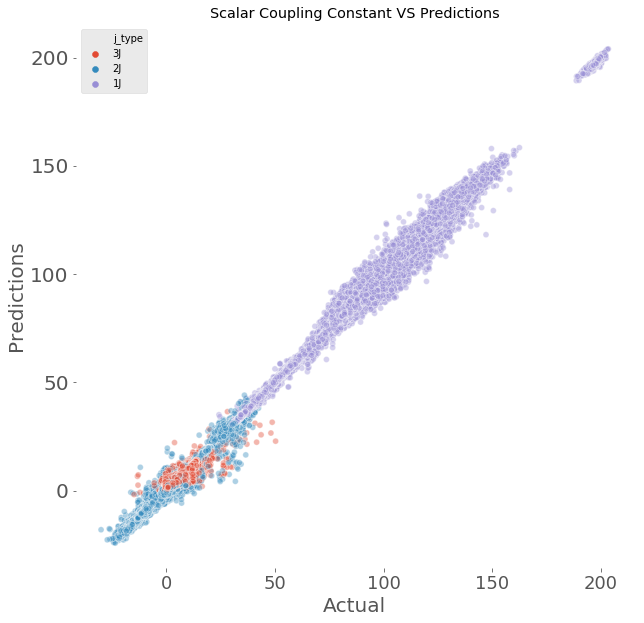

In [0]:
# palette = ['#86ACDE', '#5929E0', '#A4E6FC', '#E6090C', '#2765EB', '#1B04DB', '#911DE1', '#4353DF']
palette = ['#86ACDE', '#5929E0', '#A4E6FC']
plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
sns.scatterplot(val_final_shuffle['scalar_coupling_constant'], val_final_shuffle['preds'],
                marker='o',
                alpha=.4,
                hue=val_final['j_type'])

plt.box(False)
plt.grid(False)
plt.xlabel('Actual', fontsize=20)
plt.ylabel('Predictions', fontsize=20)
plt.title('Scalar Coupling Constant VS Predictions')
plt.legend();

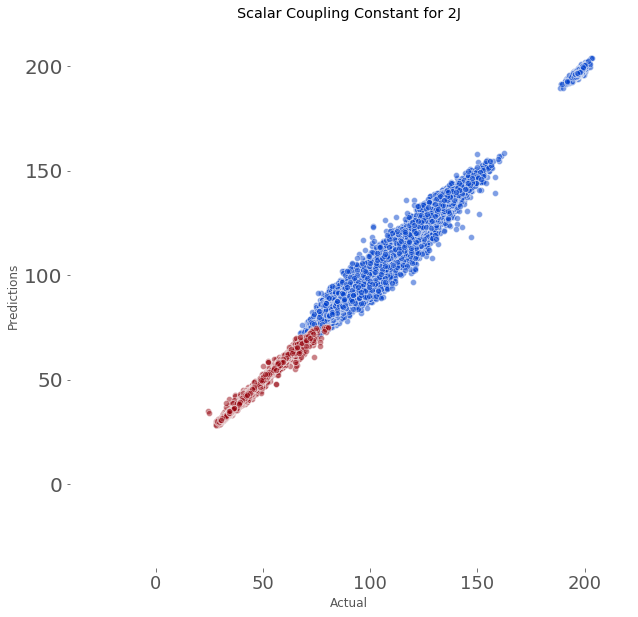

In [0]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [val_1JHC, val_1JHN]
colors = ['#0040cc', '#96040e']
names = ['1JHC', '1JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      sns.scatterplot(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title('Scalar Coupling Constant for 2J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break

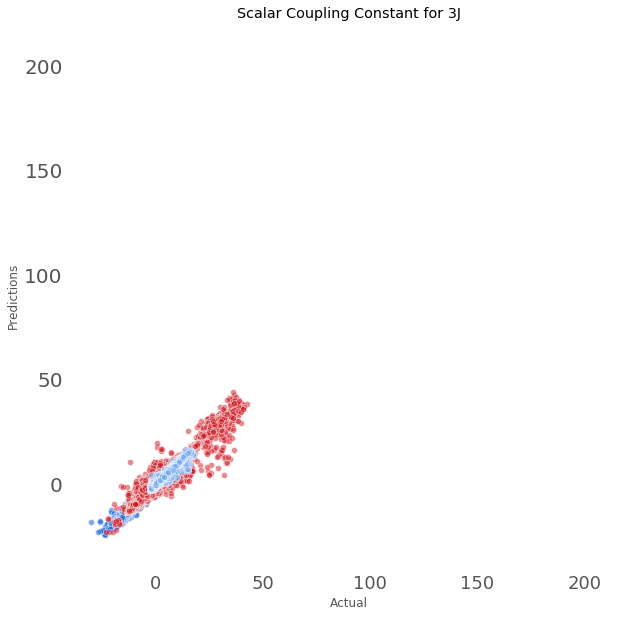

In [0]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [val_2JHH, val_2JHC, val_2JHN]
colors = ['#075be6', '#D5131C', '#6fa7f5']
names = ['2JHH', '2JHC', '2JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      sns.scatterplot(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.5)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title('Scalar Coupling Constant for 3J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.tick_params(
              axis='x',          # changes apply to the x-axis
              which='both',      # both major and minor ticks are affected
              bottom=False,      # ticks along the bottom edge are off
              top=False,         # ticks along the top edge are off
              labelbottom=True) # labels along the bottom edge are off
      plt.tick_params(
              axis='y',          # changes apply to the x-axis
              which='both',      # both major and minor ticks are affected
              bottom=False,      # ticks along the bottom edge are off
              top=False,
              left=False,        # ticks along the top edge are off
              labelbottom=False) # labels along the bottom edge are off
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

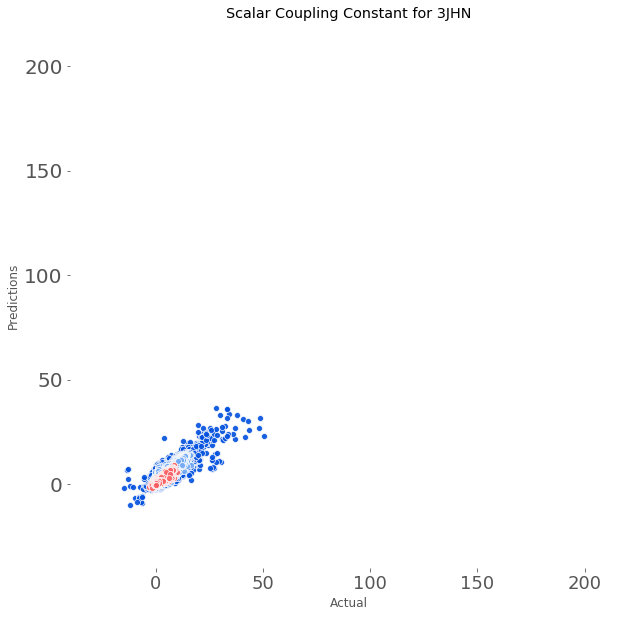

In [0]:
import seaborn as sns
plt.figure(figsize=(10, 10))
plots = [val_3JHC, val_3JHH, val_3JHN]
colors = ['#004fde', '#6fa7f5', '#F95D61']
names = ['3JHC', '3JHH', '3JHN']
for plot in plots:
  for cc in colors:
    for name in names:
      sns.scatterplot(plot['scalar_coupling_constant'], plot['preds'],
                      marker='o',
                      color=cc,
                      alpha=.9)
      plt.xlabel('Actual')
      plt.ylabel('Predictions')
      plt.title(f'Scalar Coupling Constant for 3J')
      plt.grid(False)
      plt.box(False)
      plt.xlim(-40, 220)
      plt.ylim(-40, 220)
      plt.savefig(f'{name}.png', transparent=True)
      
      names.pop(0)
      break
      
    colors.pop(0)
    break
 

## Permutation Importance

In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter_1JHC = PermutationImportance(clf_1JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_1JHC.fit(X_val_1JHC_encoded, y_val_1JHC)
feature_names_1JHC = X_val_1JHC_encoded.columns.tolist()
eli5.show_weights(permuter_1JHC, top=None, feature_names=feature_names_1JHC)

Weight,Feature
50.5899 ± 0.3155,n_bonds_y
40.3844 ± 0.0274,distance
27.8764 ± 0.2816,bond_lengths_mean_y
17.0987 ± 0.0185,mulliken_charge_1
14.8784 ± 0.0212,mulliken_charge_0
10.2739 ± 0.0834,atom_1_couples_count
8.9014 ± 0.0104,molecule_atom_index_1_dist_min
3.7380 ± 0.0256,molecule_atom_index_0_dist_min
3.1859 ± 0.0305,bond_lengths_mean_x
2.6223 ± 0.0325,molecule_atom_index_0_dist_max_div


In [0]:
df_1JHC_imp = eli5.explain_weights_df(permuter_1JHC, top=None, feature_names=feature_names_1JHC)
df_1JHC_imp = df_1JHC_imp.drop('std', axis=1)
df_1JHC_imp.head()

,feature,weight
0,n_bonds_y,50.589879
1,distance,40.384363
2,bond_lengths_mean_y,27.876447
3,mulliken_charge_1,17.098652
4,mulliken_charge_0,14.878380


In [0]:
permuter_1JHN = PermutationImportance(clf_1JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_1JHN.fit(X_val_1JHN_encoded, y_val_1JHN)
feature_names_1JHN = X_val_1JHN_encoded.columns.tolist()
eli5.show_weights(permuter_1JHN, top=None, feature_names=feature_names_1JHN)

Weight,Feature
70.9051 ± 1.7414,molecule_atom_index_1_dist_min
26.1694 ± 0.1043,mulliken_charge_0
17.2222 ± 0.4329,bond_lengths_mean_y
5.1958 ± 0.0173,mulliken_charge_1
1.2929 ± 0.0160,n_bonds_y
0.6504 ± 0.0240,molecule_atom_index_0_dist_mean_div
0.4697 ± 0.0279,distance
0.4507 ± 0.0115,atom_1_couples_count
0.3510 ± 0.0075,molecule_atom_index_0_dist_max
0.1879 ± 0.0033,distance_0


In [0]:
df_1JHN_imp = eli5.explain_weights_df(permuter_1JHN, top=None, feature_names=feature_names_1JHN)
df_1JHN_imp = df_1JHN_imp.drop('std', axis=1)
df_1JHN_imp.head()

,feature,weight
0,molecule_atom_index_1_dist_min,70.905075
1,mulliken_charge_0,26.169391
2,bond_lengths_mean_y,17.222150
3,mulliken_charge_1,5.195847
4,n_bonds_y,1.292890


In [0]:
permuter_2JHH = PermutationImportance(clf_2JHH, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHH.fit(X_val_2JHH_encoded, y_val_2JHH)
feature_names_2JHH = X_val_2JHH_encoded.columns.tolist()
eli5.show_weights(permuter_2JHH, top=None, feature_names=feature_names_2JHH)

Weight,Feature
4.9362 ± 0.0100,molecule_atom_index_1_dist_min
4.8031 ± 0.0011,distance
3.9077 ± 0.0204,bond_lengths_mean_y
0.9561 ± 0.0079,mulliken_charge_0
0.8988 ± 0.0041,mulliken_charge_1
0.5471 ± 0.0072,molecule_atom_index_0_dist_min
0.3136 ± 0.0011,bond_lengths_mean_x
0.2706 ± 0.0049,atom_0_couples_count
0.2296 ± 0.0009,molecule_atom_index_0_dist_mean
0.1261 ± 0.0014,molecule_atom_index_1_dist_mean


In [0]:
df_2JHH_imp = eli5.explain_weights_df(permuter_2JHH, top=None, feature_names=feature_names_2JHH)
df_2JHH_imp = df_2JHH_imp.drop('std', axis=1)
df_2JHH_imp.head()

,feature,weight
0,molecule_atom_index_1_dist_min,4.936211
1,distance,4.803075
2,bond_lengths_mean_y,3.907727
3,mulliken_charge_0,0.956112
4,mulliken_charge_1,0.898834


In [0]:
permuter_2JHC = PermutationImportance(clf_2JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHC.fit(X_val_2JHC_encoded, y_val_2JHC)
feature_names_2JHC = X_val_2JHC_encoded.columns.tolist()
eli5.show_weights(permuter_2JHC, top=None, feature_names=feature_names_2JHC)

Weight,Feature
4.8869 ± 0.0207,molecule_atom_index_0_dist_min
4.5158 ± 0.0223,bond_lengths_mean_x
3.1476 ± 0.0610,atom_0_couples_count
2.9844 ± 0.0134,mulliken_charge_0
2.2552 ± 0.0172,distance
1.6284 ± 0.0097,n_bonds_y
1.5771 ± 0.0007,bond_lengths_mean_y
1.3653 ± 0.0000,molecule_atom_index_0_dist_max
1.0827 ± 0.0251,mulliken_charge_1
0.9901 ± 0.0025,molecule_atom_index_1_dist_min


In [0]:
df_2JHC_imp = eli5.explain_weights_df(permuter_2JHC, top=None, feature_names=feature_names_2JHC)
df_2JHC_imp = df_2JHC_imp.drop('std', axis=1)
df_2JHC_imp.head()

,feature,weight
0,molecule_atom_index_0_dist_min,4.886943
1,bond_lengths_mean_x,4.515838
2,atom_0_couples_count,3.147587
3,mulliken_charge_0,2.984394
4,distance,2.255194


In [0]:
permuter_2JHN = PermutationImportance(clf_2JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_2JHN.fit(X_val_2JHN_encoded, y_val_2JHN)
feature_names_2JHN = X_val_2JHN_encoded.columns.tolist()
eli5.show_weights(permuter_2JHN, top=None, feature_names=feature_names_2JHN)

Weight,Feature
3.3270 ± 0.0065,n_bonds_y
2.2787 ± 0.0532,molecule_atom_index_0_dist_min
2.1103 ± 0.0029,bond_lengths_mean_x
1.5021 ± 0.0095,atom_0_couples_count
1.0320 ± 0.0048,bond_lengths_mean_y
1.0276 ± 0.0126,molecule_atom_index_0_dist_max
0.7851 ± 0.0006,distance
0.6563 ± 0.0131,molecule_atom_index_1_dist_min_diff
0.5108 ± 0.0117,mulliken_charge_0
0.5023 ± 0.0024,molecule_atom_index_0_dist_mean_div


In [0]:
df_2JHN_imp = eli5.explain_weights_df(permuter_2JHN, top=None, feature_names=feature_names_2JHN)
df_2JHN_imp = df_2JHN_imp.drop('std', axis=1)
df_2JHN_imp.head()

,feature,weight
0,n_bonds_y,3.327019
1,molecule_atom_index_0_dist_min,2.278661
2,bond_lengths_mean_x,2.110305
3,atom_0_couples_count,1.502098
4,bond_lengths_mean_y,1.031995


In [0]:
permuter_3JHH = PermutationImportance(clf_3JHH, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHH.fit(X_val_3JHH_encoded, y_val_3JHH)
feature_names_3JHH = X_val_3JHH_encoded.columns.tolist()
eli5.show_weights(permuter_3JHH, top=None, feature_names=feature_names_3JHH)

Weight,Feature
6.3154 ± 0.0660,molecule_atom_1_dist_min_div
5.0046 ± 0.0290,distance
3.5128 ± 0.0026,bond_lengths_mean_y
1.5183 ± 0.0042,bond_lengths_mean_x
0.5741 ± 0.0009,molecule_atom_index_1_dist_max
0.4073 ± 0.0011,atom_0_couples_count
0.3957 ± 0.0023,mulliken_charge_1
0.3880 ± 0.0009,molecule_atom_index_0_dist_min
0.3730 ± 0.0002,molecule_atom_1_dist_min_diff
0.2781 ± 0.0059,molecule_atom_index_0_dist_mean_diff


In [0]:
df_3JHH_imp = eli5.explain_weights_df(permuter_3JHH, top=None, feature_names=feature_names_3JHH)
df_3JHH_imp = df_3JHH_imp.drop('std', axis=1)
df_3JHH_imp.head()

,feature,weight
0,molecule_atom_1_dist_min_div,6.315368
1,distance,5.004579
2,bond_lengths_mean_y,3.512802
3,bond_lengths_mean_x,1.518287
4,molecule_atom_index_1_dist_max,0.574139


In [0]:
permuter_3JHC = PermutationImportance(clf_3JHC, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHC.fit(X_val_3JHC_encoded, y_val_3JHC)
feature_names_3JHC = X_val_3JHC_encoded.columns.tolist()
eli5.show_weights(permuter_3JHC, top=None, feature_names=feature_names_3JHC)

Weight,Feature
2.6368 ± 0.0019,distance
1.3369 ± 0.0047,bond_lengths_mean_y
0.9100 ± 0.0029,bond_lengths_mean_x
0.8407 ± 0.0067,n_bonds_y
0.7335 ± 0.0031,molecule_atom_index_0_dist_min
0.6847 ± 0.0015,mulliken_charge_1
0.6729 ± 0.0046,mulliken_charge_0
0.5107 ± 0.0013,molecule_atom_index_0_dist_mean_diff
0.4487 ± 0.0028,molecule_atom_index_1_dist_min
0.4281 ± 0.0003,molecule_atom_index_0_dist_max


In [0]:
df_3JHC_imp = eli5.explain_weights_df(permuter_3JHC, top=None, feature_names=feature_names_3JHC)
df_3JHC_imp = df_3JHC_imp.drop('std', axis=1)
df_3JHC_imp.head()

,feature,weight
0,distance,2.636834
1,bond_lengths_mean_y,1.336917
2,bond_lengths_mean_x,0.909996
3,n_bonds_y,0.840672
4,molecule_atom_index_0_dist_min,0.733543


In [0]:
permuter_3JHN = PermutationImportance(clf_3JHN, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter_3JHN.fit(X_val_3JHN_encoded, y_val_3JHN)
feature_names_3JHN = X_val_3JHN_encoded.columns.tolist()
eli5.show_weights(permuter_3JHN, top=None, feature_names=feature_names_3JHN)

Weight,Feature
0.4843 ± 0.0119,molecule_atom_index_0_dist_mean_diff
0.3066 ± 0.0053,bond_lengths_mean_x
0.2883 ± 0.0050,mulliken_charge_1
0.2728 ± 0.0005,molecule_atom_index_1_dist_min_diff
0.2612 ± 0.0031,distance
0.2036 ± 0.0025,bond_lengths_mean_y
0.1441 ± 0.0019,mulliken_charge_0
0.1048 ± 0.0009,n_bonds_y
0.0708 ± 0.0028,molecule_atom_index_1_dist_min
0.0699 ± 0.0018,molecule_atom_index_0_dist_min


In [99]:
df_3JHN_imp = eli5.explain_weights_df(permuter_3JHN, top=None, feature_names=feature_names_3JHN)
df_3JHN_imp = df_3JHN_imp.drop('std', axis=1)
df_3JHN_imp.head()

NameError: ignored

## Shapley Plot

In [0]:
import shap
data_for_prediction = X_val_1JHC_encoded[X_val_1JHC_encoded.index == 4658113]
shap.initjs()
plt.figure(figsize=(30, 30))
explainer = shap.TreeExplainer(clf_1JHC)
shap_values = explainer.shap_values(data_for_prediction)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction, matplotlib=False)


<Figure size 2160x2160 with 0 Axes>

In [0]:
import shap
data_for_prediction_2 = X_val_3JHN_encoded[X_val_3JHN_encoded.index == 3696821]
shap.initjs()
explainer = shap.TreeExplainer(clf_3JHN)
shap_values = explainer.shap_values(data_for_prediction_2)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_2, matplotlib=False)